In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

import numpy as np
import sys
DCNFDE_PATH = '/notebooks/research/depth-estimation/cs8990'
if DCNFDE_PATH not in sys.path:
    sys.path.append(DCNFDE_PATH)
from dcnfde import test_im, test_weight, ConvMap, SuperpixelPooling

def myimshow(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im[...,::-1]/255)
    
def show_unary_from(conv_map):
    H_test = np.einsum('tij,kij->tk', test_weight, conv_map)
    show_unary(H_test)
    
def show_unary(H_test):
    plt.figure(figsize=(10,7))
    plt.imshow(H_test, cmap='jet')

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, merge
from keras.layers.core import Flatten, Dense, Dropout, Merge, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import h5py
import numpy as np
import os

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 512, 28, 28)   19434304    input_1[0][0]                    
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 300, 28, 28)   0                                            
____________________________________________________________________________________________________
merge_1 (Merge)                  (None, 300, 512)      0           sequential_1[1][0]               
                                                                   input_2[0][0]           

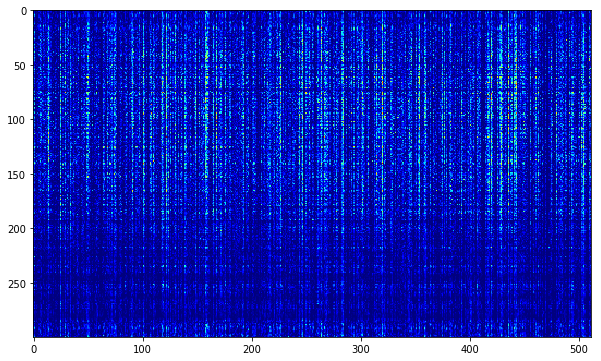

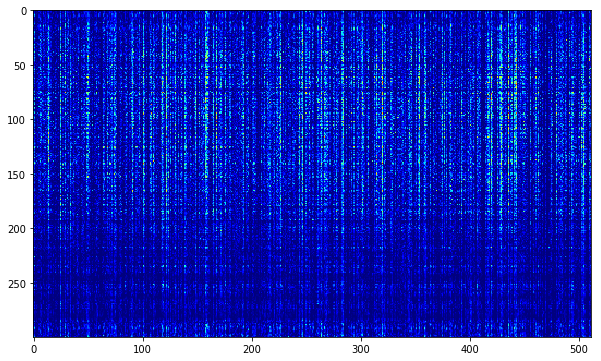

In [3]:
class SuperpixelPooling(object):
    def __init__(self, vgg_weights_path):
        convmap = ConvMap(vgg_weights_path).model
        
        images = Input(shape=(3,224,224))
        superpixels = Input(shape=(300, 28, 28))
        convmap_output = convmap(images)
        
        spp = merge([convmap_output, superpixels],
            mode = lambda (W, CM): tf.einsum('ntij,nkij->ntk', W, CM),
            output_shape = (300, 512))
        
        self.model = Model(input = [images, superpixels], output = [spp, convmap_output])
        self.model.summary()
        
    def predict_one(self, im, w):
        im = im.copy()
        im[:,:] -= np.array([103.939, 116.779, 123.68])
        im = im.transpose((2,0,1))
        im = np.expand_dims(im, axis=0)
        w = np.expand_dims(w, axis=0)
        r = self.model.predict([im, w])
        return r

sp = SuperpixelPooling('vgg16_weights.h5')
sp_ret = sp.predict_one(test_im, test_weight)
show_unary_from(sp_ret[1][0])
show_unary(sp_ret[0][0].T)

In [ ]:
class ConvMap2(object):
    def __init__(self, vgg_weights_path):
        convmap = ConvMap(vgg_weights_path).model
        identity = Sequential()
        identity.add(convmap)
        self.model = identity
        self.model.summary()

cm = ConvMap('vgg16_weights.h5')
cm2 = ConvMap2('vgg16_weights.h5')

test_input = np.random.rand(1,3,224,224)
test_A1 = cm.model.predict(test_input)
test_A2 = cm2.model.predict(test_input)
print(np.linalg.norm(test_A1-test_A2))